# Import libraries

In [36]:
import janitor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import session_info
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import statsmodels.formula.api as smf

from sklearn.linear_model import BayesianRidge
from sklearn.experimental import enable_iterative_imputer

# Import external files

- Extension of the "missing" functions from Pandas
- DataFrame and dictionary functions
- Statistical functions

In [37]:
%run utils/u.0.0-pandas_missing_extension.ipynb
%run utils/u.0.1-df_functions.ipynb
%run utils/u.0.2-statistical-functions.ipynb

# Get the processed data

In [38]:
arg_di_df = pd.read_csv('../data/processed/WDICSV_PROCESSED.csv').clean_names(case_type="snake")

print(arg_di_df.shape)
arg_di_df.info()

(54, 28)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   year                    54 non-null     int64  
 1   it_mlt_main             54 non-null     float64
 2   ny_gdp_mktp_kd_zg       54 non-null     float64
 3   ny_gdp_pcap_kd          54 non-null     float64
 4   ny_gdp_pcap_kd_zg       54 non-null     float64
 5   sp_dyn_le00_in          53 non-null     float64
 6   it_cel_sets             50 non-null     float64
 7   sh_dth_imrt             53 non-null     float64
 8   sp_pop_0014_to_zs       54 non-null     float64
 9   sp_pop_1564_to_zs       54 non-null     float64
 10  sp_pop_65_up_to_zs      54 non-null     float64
 11  sp_pop_totl             54 non-null     float64
 12  sm_pop_refg             54 non-null     float64
 13  sm_pop_refg_or          44 non-null     float64
 14  se_pre_enrr             45 non-null

# Get indicators names and codes

In [39]:
indicators_names = [item + ", " + get_indicator_name(item, True) for item in arg_di_df.columns]
indicators_names

['year, Year',
 'it_mlt_main, Fixed telephone subscriptions',
 'ny_gdp_mktp_kd_zg, GDP growth (annual %)',
 'ny_gdp_pcap_kd, GDP per capita (constant 2015 US$)',
 'ny_gdp_pcap_kd_zg, GDP per capita growth (annual %)',
 'sp_dyn_le00_in, Life expectancy at birth, total (years)',
 'it_cel_sets, Mobile cellular subscriptions',
 'sh_dth_imrt, Number of infant deaths',
 'sp_pop_0014_to_zs, Population ages 0-14 (% of total population)',
 'sp_pop_1564_to_zs, Population ages 15-64 (% of total population)',
 'sp_pop_65_up_to_zs, Population ages 65 and above (% of total population)',
 'sp_pop_totl, Population, total',
 'sm_pop_refg, Refugee population by country or territory of asylum',
 'sm_pop_refg_or, Refugee population by country or territory of origin',
 'se_pre_enrr, School enrollment, preprimary (% gross)',
 'se_prm_enrr, School enrollment, primary (% gross)',
 'se_sec_enrr, School enrollment, secondary (% gross)',
 'se_ter_enrr, School enrollment, tertiary (% gross)',
 'sp_urb_totl_in_zs,

# Get columns

## Numeric and categorical variables

In [40]:
categorical_cols = arg_di_df.select_dtypes(include=['object']).columns
numeric_cols = arg_di_df.select_dtypes(include=['number']).columns

## Columns with missing values

In [41]:
columns_with_missing_values = get_columns_with_missing_values(arg_di_df)
columns_with_missing_values

['se_ter_enrr',
 'sm_pop_refg_or',
 'se_pre_enrr',
 'se_prm_enrr',
 'se_sec_enrr',
 'it_cel_sets',
 'it_cel_sets_pct',
 'sp_dyn_le00_in',
 'sh_dth_imrt']

# Target variable:

sp_dyn_le00_in (Life expectancy at birth, total (years))

In [42]:
target_variable = "sp_dyn_le00_in"
target_variable_name = get_indicator_name(target_variable, True)

## Univariate analysis

In [43]:
arg_di_df[[target_variable]].describe()

,sp_dyn_le00_in
count,53.000000
mean,72.400774
std,3.599354
min,65.541000
25%,69.195000
50%,73.172000
75%,75.641000
max,77.284000


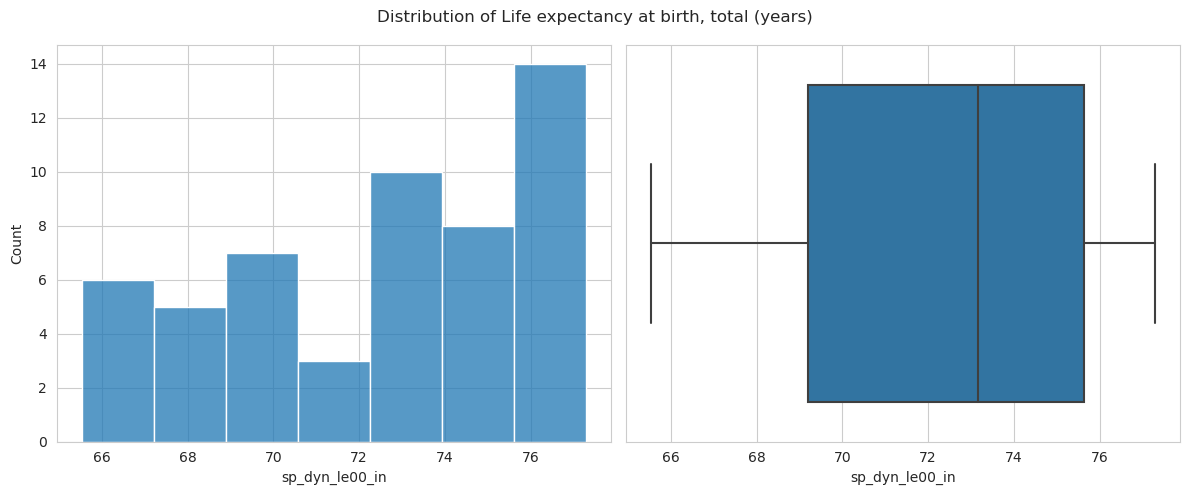

In [44]:
fig, axes = plt.subplots(1,2,figsize=(12,5))

sns.histplot(data=arg_di_df, x=target_variable, ax=axes[0])
sns.boxplot(data=arg_di_df, x=target_variable, ax=axes[1])

fig.suptitle(f"Distribution of {target_variable_name}")
plt.tight_layout()
plt.show()

In [45]:
skewness = arg_di_df[target_variable].skew()
kurtosis = arg_di_df[target_variable].kurt()

print(f"Skewness of {target_variable_name}: {skewness}")
print(f"Kurtosis of {target_variable_name}: {kurtosis}")

Skewness of Life expectancy at birth, total (years): -0.44591279746203305
Kurtosis of Life expectancy at birth, total (years): -1.1097845518321208


In [46]:
detect_outliers(arg_di_df, [target_variable])

Outliers detection:
There are no outliers for Life expectancy at birth, total (years)


# Analyze the relationship between the target variable and the other variables 

## Correlation

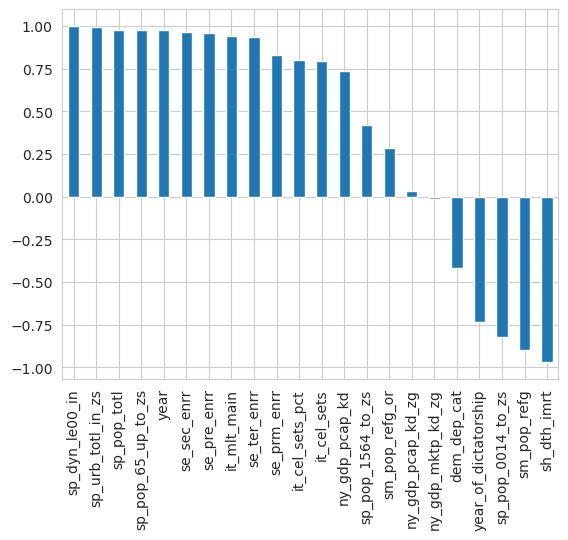

In [47]:
arg_di_df.corr(numeric_only=True)[target_variable].sort_values(ascending=False).plot(kind="bar")
plt.show()

## Bivariate distribution

/home/ubuntu/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


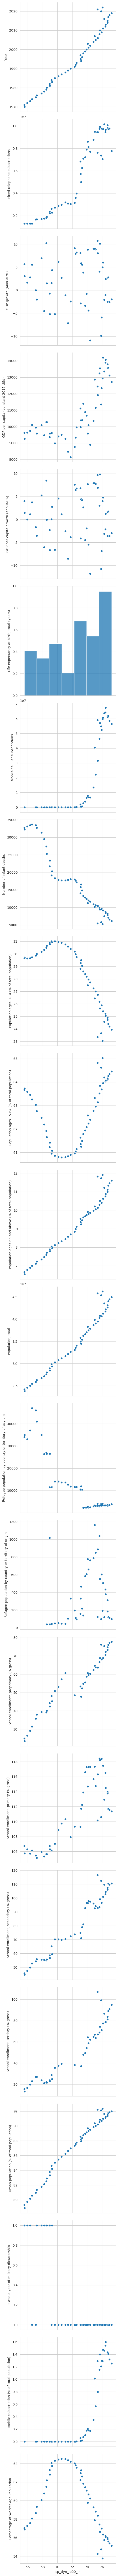

In [64]:
pairplot = sns.pairplot(data=arg_di_df, x_vars=[target_variable], y_vars=numeric_cols,height=5,aspect=1)

for i,ax in enumerate(pairplot.axes[:,0]):
    ax.set_ylabel(get_indicator_name(numeric_cols[i],True))
    
plt.show()

## Categorical variables

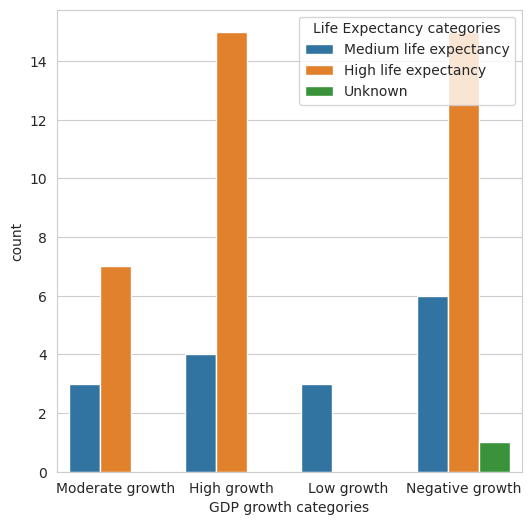

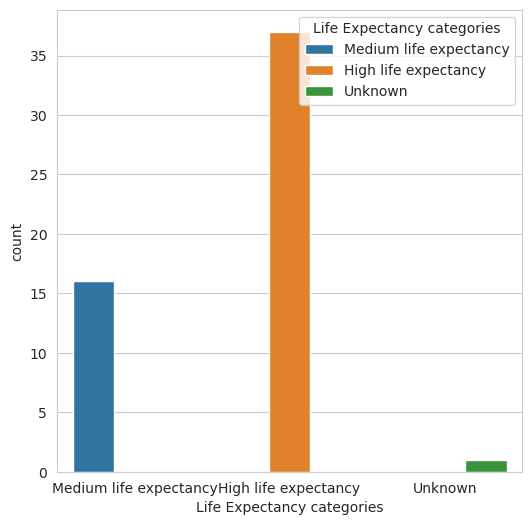

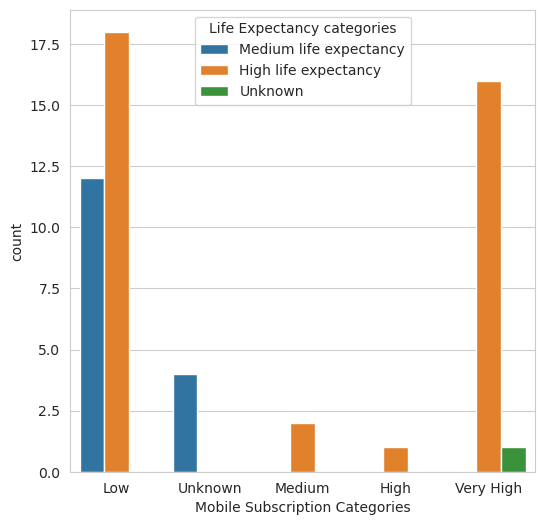

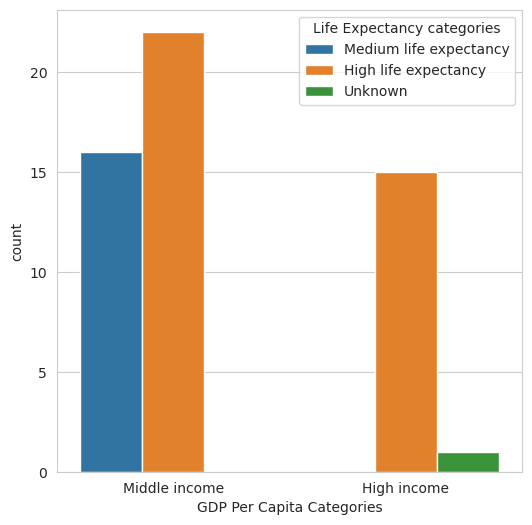

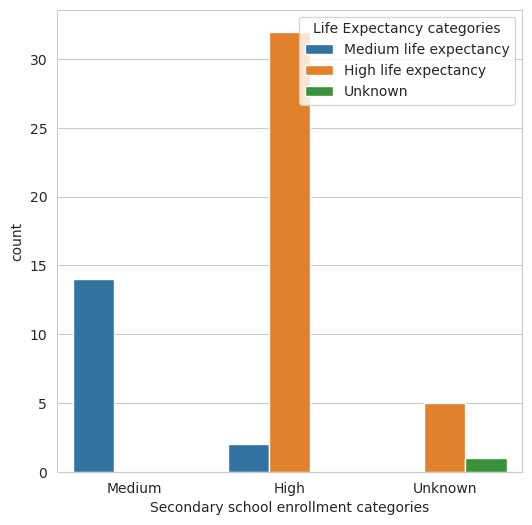

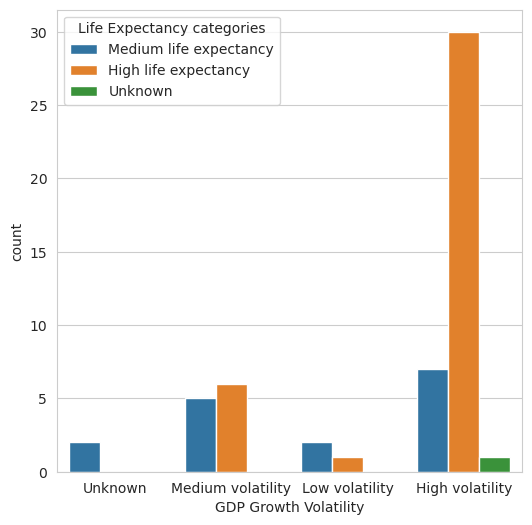

In [71]:
def plot_categorical(data, column, hue=(target_variable+"_cat")):
    fig = plt.figure(figsize=(6,6))
    sns.countplot(data=data, x=column, hue=hue)
    plt.xlabel(get_indicator_name(column,True))
    plt.legend(title=get_indicator_name(hue,True))
    plt.show()

for col in categorical_cols:
    plot_categorical(arg_di_df, col)

# Apply statistical functions

## TTest

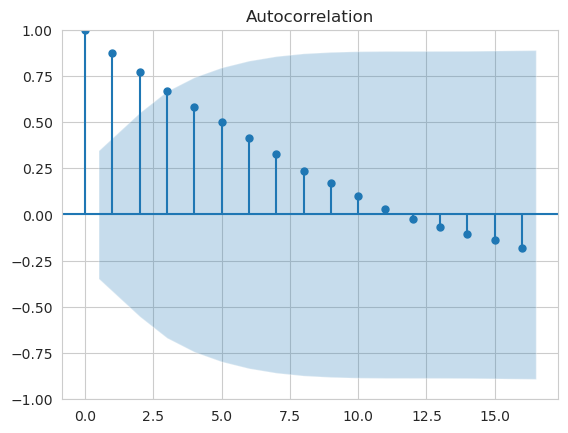

Normality of sample 0? False
Normality of sample 1? False
Equality of variances? True


TtestResult(statistic=-6.492353268172686, pvalue=7.771964816118865e-08, df=42.0)

In [50]:
def get_groups_of_missing_values(data, grouping_variable, grouped_variable):

    indexes_of_grouping_variable = arg_di_df.value_counts(grouping_variable, dropna=False).index
    
    grouped_variable = columns_with_missing_values[0]
    grouped_variable_description = get_indicator_name(grouped_variable, True)

    groupby_series = (
        data
            .rename(columns={grouped_variable: grouped_variable_description})
            .loc[:,[grouping_variable, grouped_variable_description]]
            .dropna()
            .groupby(grouping_variable)
    )

    group_1 = pd.DataFrame() if groupby_series.indices.get(indexes_of_grouping_variable[1]) is None else groupby_series.get_group(indexes_of_grouping_variable[1]).loc[:,grouped_variable_description]
    group_2 = pd.DataFrame() if groupby_series.indices.get(indexes_of_grouping_variable[0]) is None else groupby_series.get_group(indexes_of_grouping_variable[0]).loc[:,grouped_variable_description]

    return group_1, group_2

group_1, group_2 = get_groups_of_missing_values(arg_di_df, "year_of_dictatorship", columns_with_missing_values[1])

ttest_ind_and_conditions(group_1,group_2)

What does this plot tell us about the data?

* There is significant autocorrelation at lower lags (strong dependency on past values).
* The autocorrelation decreases over time, eventually turning negative.
* This pattern suggests the data is not purely random and could be modeled using time series techniques, such as an ARMA or ARIMA model (AutoRegressive Moving Average and AutoRegressive Integrated Moving Average respectively)

## Regplot

<Axes: xlabel='se_ter_enrr', ylabel='sm_pop_refg_or'>

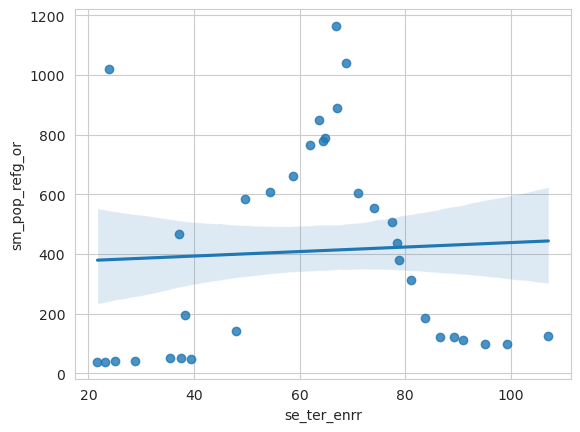

In [51]:
sns.regplot(data=arg_di_df,x=columns_with_missing_values[0],y=columns_with_missing_values[1], ci=80)

In [52]:
t_interval(arg_di_df, columns_with_missing_values[0], columns_with_missing_values[1])


(array([nan, nan]), array([nan, nan]))

# Transform categorical variables

## Ordinal coding

This method implies to transform every category into an integer

### Apply to a column

In [53]:
encoder = sklearn.preprocessing.OrdinalEncoder()

X= [[item] for item in arg_di_df[categorical_columns[0]].unique().tolist()]

X

NameError: name 'categorical_columns' is not defined

In [ ]:
# Fit to data, then transform it.
encoder.fit_transform(X)

array([[2.],
       [0.],
       [1.],
       [3.]])

In [ ]:
encoder.categories_

[array(['High growth', 'Low growth', 'Moderate growth', 'Negative growth'],
       dtype=object)]

In [ ]:
encoder.inverse_transform([[0],[1],[2],[3]])

array([['High growth'],
       ['Low growth'],
       ['Moderate growth'],
       ['Negative growth']], dtype=object)

### Apply to a group of columns


Column transformer: Applies transformers to columns of an array or pandas DataFrame.

make_column_transformer(): Construct a ColumnTransformer from the given transformers. This is a shorthand for the ColumnTransformer constructor; it does not require, and does not permit, naming the transformers. Instead, they will be given names automatically based on their types.


In [ ]:
categorical_transformer = sklearn.compose.make_column_transformer(
    # Tuples of the form (transformer, columns) specifying the transformer objects to be applied to subsets of the data
    (sklearn.preprocessing.OrdinalEncoder(), categorical_columns),
    remainder="passthrough"
    # By specifying remainder='passthrough', all remaining columns that were not specified in transformers,
    # but present in the data passed to fit will be automatically passed through. This subset of columns is
    # concatenated with the output of the transformers. For dataframes, extra columns not seen during fit
    # will be excluded from the output of transform. 
)

In [ ]:
arg_di_df_transformed = (
    pd.DataFrame(
        categorical_transformer.fit_transform(arg_di_df),
        columns=categorical_transformer.get_feature_names_out(),
        index=arg_di_df.index
    )
    .rename(
        columns=remove_prefix
    )
)

In [ ]:
arg_di_df_transformed[categorical_columns].head(5)

,ny_gdp_mktp_kd_zg_cat,sp_dyn_le00_in_cat,sm_pop_refg_cat,greatest_year_range
0,2.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0
2,1.0,1.0,0.0,0.0
3,2.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0
5,3.0,1.0,0.0,0.0
6,3.0,1.0,0.0,0.0
7,0.0,1.0,0.0,0.0
8,3.0,1.0,0.0,0.0
9,0.0,1.0,0.0,0.0


## One hot encoding vs GetDummies

Create a matrix with a column for every categorical variable. Is more useful when there are many possible values.

Getdummies doesn't create a column for either variables that not has a certain value or missing values.

In [ ]:
arg_di_df_transformed_2 = arg_di_df.copy(deep=True)

In [ ]:
(
    arg_di_df_transformed_2
        .select(columns=categorical_columns[0])
        .pipe(pd.get_dummies)
)

# Another way to write that code: pd.get_dummies(data=arg_di_df_transformed_2.select(columns=categorical_columns[0]))

,ny_gdp_mktp_kd_zg_cat_Negative growth,ny_gdp_mktp_kd_zg_cat_Low growth,ny_gdp_mktp_kd_zg_cat_Moderate growth,ny_gdp_mktp_kd_zg_cat_High growth
0,False,False,True,False
1,False,False,False,True
2,False,True,False,False
3,False,False,True,False
4,False,False,False,True
5,True,False,False,False
6,True,False,False,False
7,False,False,False,True
8,True,False,False,False
9,False,False,False,True


In [ ]:
transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(),[categorical_columns[0]]),
    (sklearn.preprocessing.OneHotEncoder(),[categorical_columns[0]]),
    remainder="passthrough"
)

In [ ]:
arg_di_df_transformed_2 = (
    pd.DataFrame(
        transformer.fit_transform(arg_di_df),
        columns=transformer.get_feature_names_out(),
        index=arg_di_df.index
    )
)

print(categorical_columns[0])
arg_di_df_transformed_2[arg_di_df_transformed_2.columns[arg_di_df_transformed_2.columns.str.contains(categorical_columns[0])]].head(5)

ny_gdp_mktp_kd_zg_cat


,ordinalencoder__ny_gdp_mktp_kd_zg_cat,onehotencoder__ny_gdp_mktp_kd_zg_cat_High growth,onehotencoder__ny_gdp_mktp_kd_zg_cat_Low growth,onehotencoder__ny_gdp_mktp_kd_zg_cat_Moderate growth,onehotencoder__ny_gdp_mktp_kd_zg_cat_Negative growth
0,2.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0
3,2.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0
5,3.0,0.0,0.0,0.0,1.0
6,3.0,0.0,0.0,0.0,1.0
7,0.0,1.0,0.0,0.0,0.0
8,3.0,0.0,0.0,0.0,1.0
9,0.0,1.0,0.0,0.0,0.0


In [ ]:
(
    transformer
    .named_transformers_
    .get("onehotencoder")
    .categories_
)

[array(['High growth', 'Low growth', 'Moderate growth', 'Negative growth'],
       dtype=object)]

In [ ]:
(
    transformer
    .named_transformers_
    .get("onehotencoder")
    .inverse_transform(
        X = [[0, 1, 0, 0]]
    )
)

array([['Low growth']], dtype=object)

# Data imputation

## Imputation by mean

With function made during the course

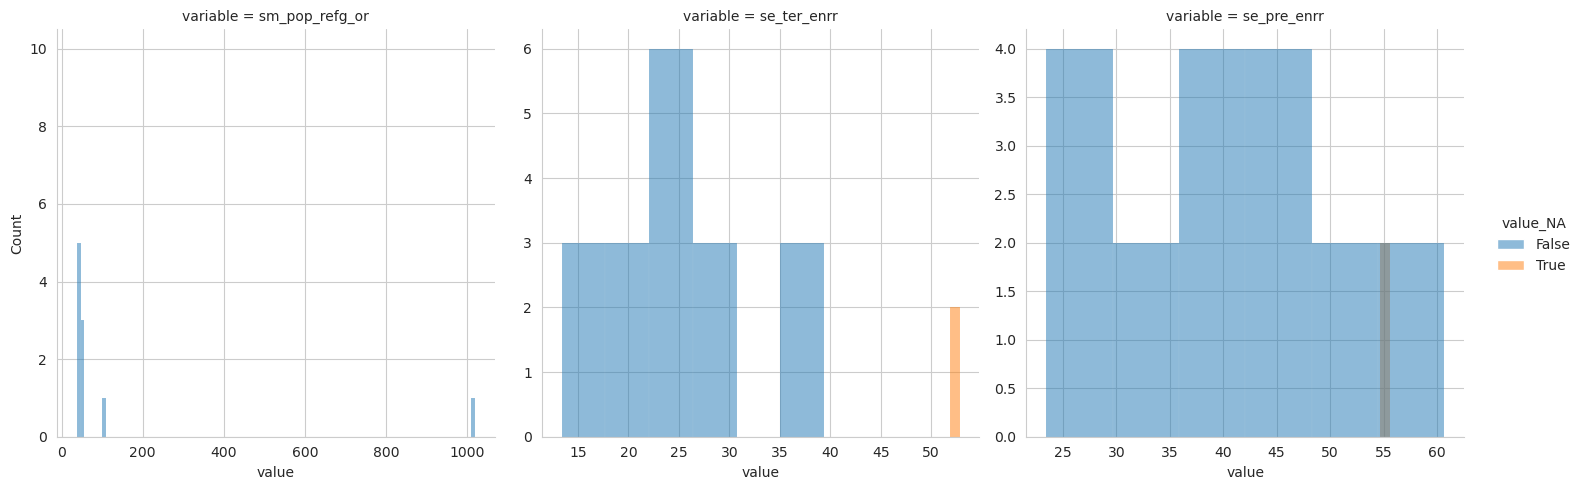

In [ ]:
plot_imputation_by_mean(arg_di_df,[columns_with_missing_values[0], columns_with_missing_values[1], columns_with_missing_values[2]])

In [ ]:
imputation_of_missing_variable(shadow_matrix, columns_with_missing_values[0])

NameError: name 'imputation_of_missing_variable' is not defined

## Imputation by mean, median and mode

In [ ]:
arg_di_df_single_imputation = arg_di_df.copy()
arg_di_df_single_imputation[columns_with_missing_values[0] + "_mean"] = arg_di_df_single_imputation[columns_with_missing_values[0]].fillna(arg_di_df_single_imputation[columns_with_missing_values[0]].mean())
arg_di_df_single_imputation[columns_with_missing_values[0] + "_mode"] = arg_di_df_single_imputation[columns_with_missing_values[0]].fillna(arg_di_df_single_imputation[columns_with_missing_values[0]].mode().iloc[0]) #Arbitrary choice of taking the first mode
arg_di_df_single_imputation[columns_with_missing_values[0] + "_median"] = arg_di_df_single_imputation[columns_with_missing_values[0]].fillna(arg_di_df_single_imputation[columns_with_missing_values[0]].median())

In [ ]:

arg_di_df_single_imputation.head()
imputation_columns = [col for col in arg_di_df_single_imputation.columns if col.startswith(columns_with_missing_values[0])]
print(arg_di_df_single_imputation[imputation_columns])

    sm_pop_refg_or  sm_pop_refg_or_mean  sm_pop_refg_or_mode  \
0              NaN           358.977273                 38.0   
1              NaN           358.977273                 38.0   
2              NaN           358.977273                 38.0   
3              NaN           358.977273                 38.0   
4              NaN           358.977273                 38.0   
5              NaN           358.977273                 38.0   
6              NaN           358.977273                 38.0   
7              NaN           358.977273                 38.0   
8              NaN           358.977273                 38.0   
9              NaN           358.977273                 38.0   
10            38.0            38.000000                 38.0   
11            38.0            38.000000                 38.0   
12          1019.0          1019.000000               1019.0   
13            42.0            42.000000                 42.0   
14            42.0            42.000000 

In [ ]:
arg_di_df_shadow_matrix = arg_di_df.missing.bind_shadow_matrix(true_string = True, false_string = False, suffix = "_imp")#[[columns_with_missing_values[0]+"_imp",new_variable_name_0,new_variable_name_0 + "_imp"]]
arg_di_df_shadow_matrix.head(5)

,year,it_mlt_main,ny_gdp_mktp_kd,ny_gdp_mktp_kd_zg,ny_gdp_pcap_kd,ny_gdp_pcap_kd_zg,sp_dyn_le00_in,it_cel_sets,sh_dth_imrt,sh_dth_mort,...,se_ter_enrr_imp,sp_urb_totl_in_zs_imp,year_of_dictatorship_imp,sp_pop_00_up_to_zs_imp,sp_totl_zs_imp,ny_gdp_mktp_kd_zg_cat_imp,sp_dyn_le00_in_cat_imp,sm_pop_refg_pct_imp,sm_pop_refg_cat_imp,greatest_year_range_imp
0,1970,1287000.0,2.207342e+11,3.045643,9257.895572,1.443200,65.589,0.0,32198.0,NaN,...,False,False,False,False,False,False,False,False,False,False
1,1971,1287000.0,2.332236e+11,5.658131,9628.037838,3.998125,65.541,NaN,32685.0,NaN,...,False,False,False,False,False,False,False,False,False,False
2,1972,1287000.0,2.370215e+11,1.628417,9630.010366,0.020487,65.923,NaN,33079.0,NaN,...,False,False,False,False,False,False,False,False,False,False
3,1973,1287000.0,2.436859e+11,2.811754,9739.416271,1.136093,66.323,NaN,33442.0,NaN,...,False,False,False,False,False,False,False,False,False,False
4,1974,1287000.0,2.571710e+11,5.533804,10105.049508,3.754160,66.563,NaN,33629.0,40082.0,...,False,False,False,False,False,False,False,False,False,False
5,1975,1651000.0,2.570980e+11,-0.028412,9935.938635,-1.673528,67.081,0.0,33434.0,39640.0,...,False,False,False,False,False,False,False,False,False,False
6,1976,1678000.0,2.519091e+11,-2.018252,9581.841403,-3.563803,67.228,0.0,32686.0,38536.0,...,False,False,False,False,False,False,False,False,False,False
7,1977,1692000.0,2.693768e+11,6.934148,10083.815183,5.238803,67.861,0.0,31346.0,36750.0,...,False,False,False,False,False,False,False,False,False,False
8,1978,1728000.0,2.572384e+11,-4.506125,9476.063436,-6.027002,68.197,0.0,29499.0,34382.0,...,False,False,False,False,False,False,False,False,False,False
9,1979,1797000.0,2.835352e+11,10.222763,10278.924624,8.472518,68.491,0.0,27357.0,31734.0,...,False,False,False,False,False,False,False,False,False,False


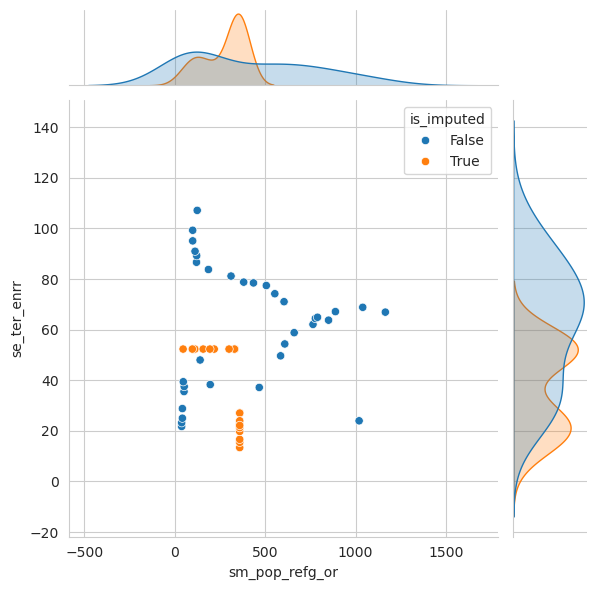

In [ ]:
arg_di_df_shadow_matrix = arg_di_df.missing.bind_shadow_matrix(True, False, suffix = "_imp")

arg_di_df_shadow_matrix = (
    arg_di_df_shadow_matrix.assign(
            **{
                columns_with_missing_values[0]: lambda df: df[columns_with_missing_values[0]].fillna(df[columns_with_missing_values[0]].mean()),
                columns_with_missing_values[1]: lambda df: df[columns_with_missing_values[1]].fillna(df[columns_with_missing_values[1]].mean())
            }
        )
)

arg_di_df_shadow_matrix.missing.scatter_imputation_plot(x=columns_with_missing_values[0], y=columns_with_missing_values[1],show_marginal=True)

## Imputation by interpolation

In [ ]:
arg_di_df['it_cel_sets'] = arg_di_df['it_cel_sets'].ffill()
print(arg_di_df.iloc[0:10][['year','it_cel_sets']])
arg_di_df['it_cel_sets'].isna().value_counts()

    year  it_cel_sets
10  1970          0.0
11  1971          0.0
12  1972          0.0
13  1973          0.0
14  1974          0.0
15  1975          0.0
16  1976          0.0
17  1977          0.0
18  1978          0.0
19  1979          0.0


it_cel_sets
False    54
Name: count, dtype: int64

Interpolation: Using ffill() and bfill()

If you are not working with time series, you must first sort the rows by correlated variables to get a more correct filling of missing values

In [ ]:
arg_di_df_single_imputation[columns_with_missing_values[4] + "_ffill"] = arg_di_df_single_imputation[columns_with_missing_values[4]].ffill()
arg_di_df_single_imputation[columns_with_missing_values[4] + "_bfill"] = arg_di_df_single_imputation[columns_with_missing_values[4]].bfill()
arg_di_df_single_imputation[[columns_with_missing_values[4], columns_with_missing_values[4] + "_ffill", columns_with_missing_values[4] + "_bfill"]].head(5)

,se_sec_enrr,se_sec_enrr_ffill,se_sec_enrr_bfill
0,44.709621,44.709621,44.709621
1,45.642109,45.642109,45.642109
2,47.472710,47.472710,47.472710
3,49.939709,49.939709,49.939709
4,52.762390,52.762390,52.762390
5,54.387550,54.387550,54.387550
6,55.880482,55.880482,55.880482
7,55.626678,55.626678,55.626678
8,55.343731,55.343731,55.343731
9,54.966290,54.966290,54.966290


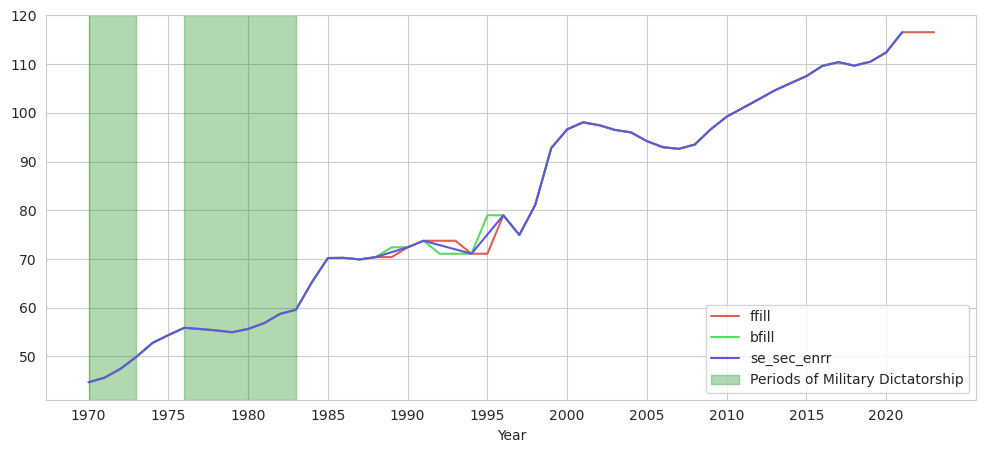

In [ ]:
time_series(data=arg_di_df_single_imputation, x="year", y=[columns_with_missing_values[4] + "_ffill", columns_with_missing_values[4] + "_bfill", columns_with_missing_values[4]], plot_labels=["ffill", "bfill", columns_with_missing_values[4]])

<Axes: >

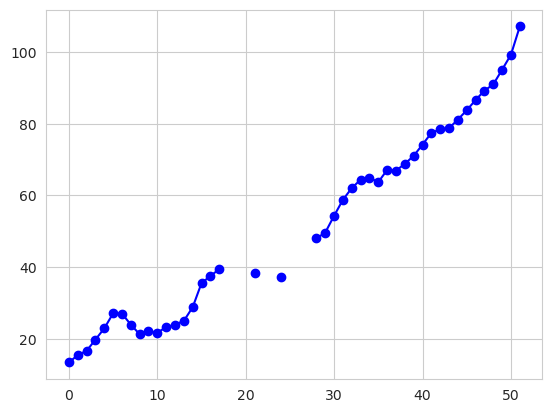

In [ ]:
arg_di_df[columns_with_missing_values[1]].plot(marker="o", color="blue")

(<Axes: >, <Axes: >)

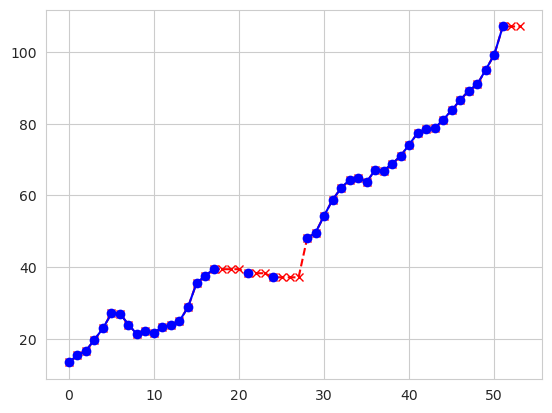

In [ ]:
arg_di_df.pipe(
    lambda df: (
        df[columns_with_missing_values[1]].ffill().plot(color="red",marker="x",linestyle="dashed"),
        df[columns_with_missing_values[1]].plot(color="blue",marker="o")
    )
)

(<Axes: >, <Axes: >)

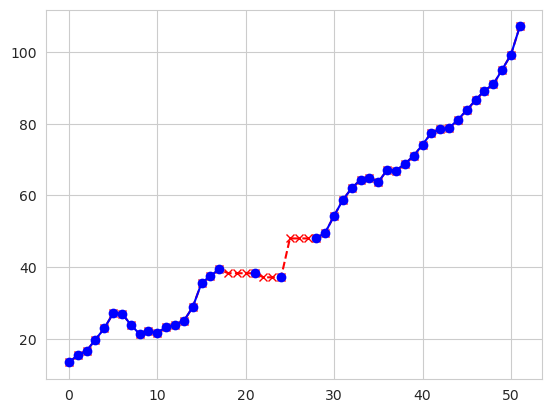

In [ ]:
arg_di_df.pipe(
    lambda df: (
        df[columns_with_missing_values[1]].bfill().plot(color="red",marker="x",linestyle="dashed"),
        df[columns_with_missing_values[1]].plot(color="blue",marker="o")
    )
)

(<Axes: >, <Axes: >)

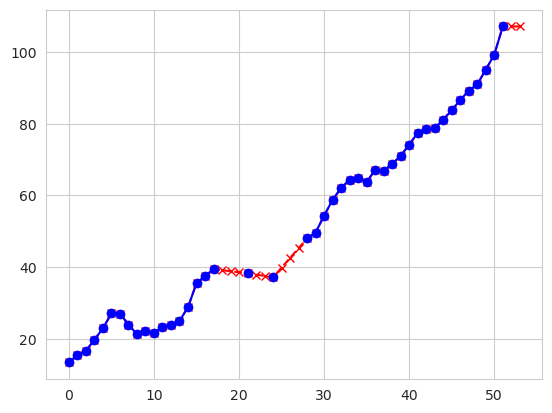

In [ ]:
arg_di_df.pipe(
    lambda df: (
        df[columns_with_missing_values[1]].interpolate(method="linear").plot(color="red",marker="x",linestyle="dashed"),
        df[columns_with_missing_values[1]].plot(color="blue",marker="o")
    )
)

(<Axes: >, <Axes: >)

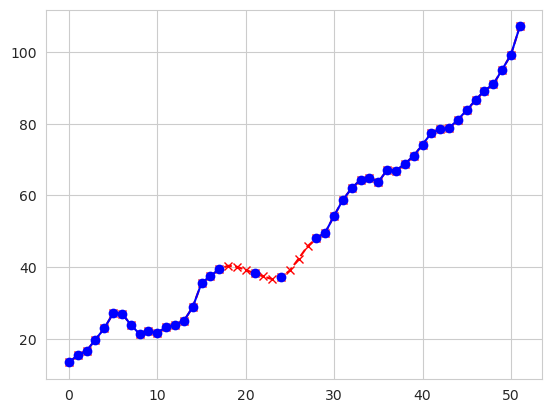

In [ ]:
arg_di_df.pipe(
    lambda df: (
        df[columns_with_missing_values[1]].interpolate(method="quadratic").plot(color="red",marker="x",linestyle="dashed"),
        df[columns_with_missing_values[1]].plot(color="blue",marker="o")
    )
)

(<Axes: >, <Axes: >)

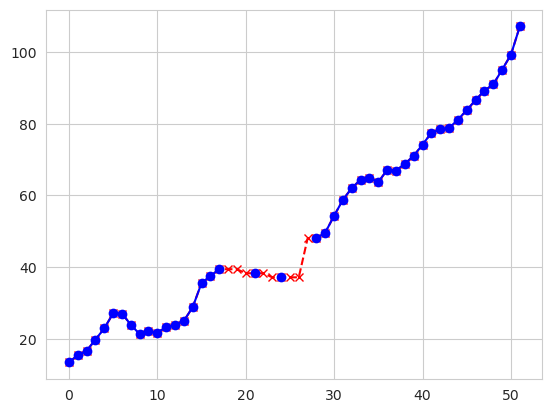

In [ ]:
arg_di_df.pipe(
    lambda df: (
        df[columns_with_missing_values[1]].interpolate(method="nearest").plot(color="red",marker="x",linestyle="dashed"),
        df[columns_with_missing_values[1]].plot(color="blue",marker="o")
    )
)

## Imputation by K-NN

For using this type of imputation, you must sort the variables by missingness

In [ ]:
knn_imputer = sklearn.impute.KNNImputer()

arg_di_df_knn = arg_di_df_transformed.missing.sort_variables_by_missingness(ascending=True).copy()
arg_di_df_knn.iloc[:,:] = knn_imputer.fit_transform(arg_di_df_knn)
arg_di_df_knn.head(5)

/home/ubuntu/anaconda3/envs/research-on-argentina/lib/python3.11/site-packages/numpy/ma/extras.py:617: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  scl = avg.dtype.type(a.count(axis))
/home/ubuntu/anaconda3/envs/research-on-argentina/lib/python3.11/site-packages/numpy/ma/extras.py:617: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  scl = avg.dtype.type(a.count(axis))
/home/ubuntu/anaconda3/envs/research-on-argentina/lib/python3.11/site-packages/numpy/ma/extras.py:617: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before perf

,ny_gdp_mktp_kd_zg_cat,sp_pop_00_up_to_zs,year_of_dictatorship,sp_urb_totl_in_zs,sp_rur_totl_zs,sm_pop_refg,sp_pop_totl,sp_pop_65_up_to_zs,sp_pop_1564_to_zs,sp_totl_zs,...,sp_dyn_le00_in,sh_dth_imrt,sp_dyn_le00_in_cat,it_cel_sets,sh_dth_mort,se_sec_enrr,se_prm_enrr,se_pre_enrr,sm_pop_refg_or,se_ter_enrr
0,2.0,100.0,1.0,78.88,21.12,35000.0,23842803.0,6.549159,63.733577,100.0,...,65.589,32198.0,1.0,0.0,34598.0,44.709621,105.769478,23.44487,308.6,13.37759
1,0.0,100.0,1.0,79.321,20.679,34000.0,24223379.0,6.671836,63.671716,100.0,...,65.541,32685.0,1.0,2400.0,34598.0,45.642109,106.752098,24.93766,308.6,15.44098
2,1.0,100.0,1.0,79.743,20.257,33000.0,24612794.0,6.784189,63.584961,100.0,...,65.923,33079.0,1.0,2400.0,34598.0,47.47271,106.286819,26.51997,308.6,16.62081
3,2.0,100.0,1.0,80.158,19.842,37000.0,25020588.0,6.893361,63.45399,100.0,...,66.323,33442.0,1.0,2400.0,34598.0,49.939709,105.710747,29.06558,308.6,19.751631
4,0.0,100.0,0.0,80.567,19.433,47000.0,25449754.0,7.000254,63.260447,100.0,...,66.563,33629.0,1.0,2400.0,40082.0,52.76239,106.127319,31.40225,308.6,22.883011
5,3.0,100.0,0.0,80.969,19.031,46000.0,25875558.0,7.112786,63.02713,100.0,...,67.081,33434.0,1.0,0.0,39640.0,54.38755,105.47226,35.701939,308.6,27.07716
6,3.0,100.0,1.0,81.366,18.634,41010.0,26290257.0,7.230755,62.762791,100.0,...,67.228,32686.0,1.0,0.0,38536.0,55.880482,105.146507,37.910751,308.6,27.01174
7,0.0,100.0,1.0,81.755,18.245,35000.0,26713780.0,7.353308,62.479922,100.0,...,67.861,31346.0,1.0,0.0,36750.0,55.626678,105.946831,39.397282,308.6,23.964741
8,3.0,100.0,1.0,82.139,17.861,26390.0,27146121.0,7.479966,62.194376,100.0,...,68.197,29499.0,1.0,0.0,34382.0,55.343731,105.351021,37.730635,308.6,21.250999
9,0.0,100.0,1.0,82.516,17.484,27050.0,27584134.0,7.59906,61.914028,100.0,...,68.491,27357.0,1.0,0.0,31734.0,54.96629,105.662491,39.189339,74.0,22.12047


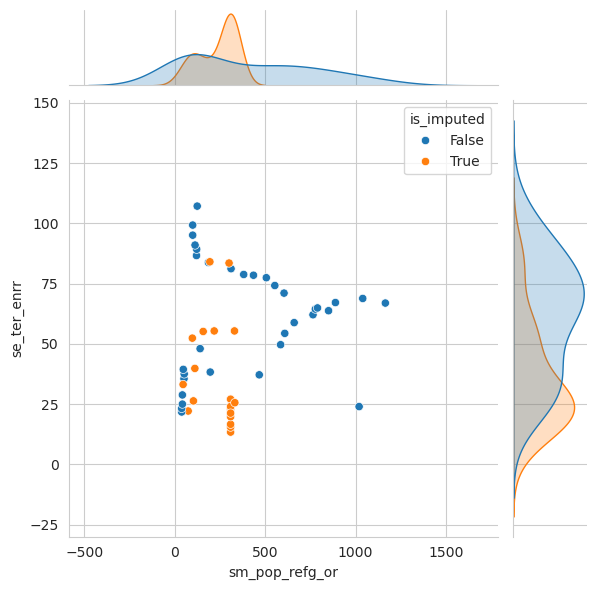

In [ ]:

(
    pd.concat(
        [
            arg_di_df_knn,
            arg_di_df.missing.create_shadow_matrix(True, False, suffix="_imp", only_missing=True)
        ],
        axis=1
    )
    .missing.scatter_imputation_plot(x=columns_with_missing_values[0], y=columns_with_missing_values[1],show_marginal=True)
)

## Model Based Imputation

### Ordinary Least Squares (OLS)

In [ ]:
(
    smf.ols(
        formula="se_ter_enrr ~ se_pre_enrr + se_sec_enrr", # Regression formula: dependent variable (the variable being predicted) ~ independent variables
        data = arg_di_df
    )
    .fit() # Computes the regression model based on the given data
    .summary() # Provides a detailed report of the regression results
    .tables[0] # Selects the first table from the summary, which contains high-level model details
)

Dep. Variable:,se_ter_enrr,R-squared:,0.959
Model:,OLS,Adj. R-squared:,0.957
Method:,Least Squares,F-statistic:,461.8
Date:,"Thu, 27 Mar 2025",Prob (F-statistic):,7.04e-28
Time:,21:59:46,Log-Likelihood:,-128.87
No. Observations:,42,AIC:,263.7
Df Residuals:,39,BIC:,269.0
Df Model:,2,,
Covariance Type:,nonrobust,,


In [ ]:
arg_di_df_model = (
    arg_di_df
        .select(columns=["se_ter_enrr", "se_pre_enrr", "se_sec_enrr", "year"])
        .sort_values(by="se_ter_enrr")
        .transform_column( #If a dependent variable has NA values, then they predict NA results
            "se_pre_enrr",
            lambda x: x.ffill(),
            elementwise = False
        )
        .transform_column(
            "se_sec_enrr",
            lambda x: x.ffill(),
            elementwise = False
        )
        .missing.bind_shadow_matrix(
            True,
            False,
            False,
            "_imp"
        )
)

arg_di_df_model.head()

,se_ter_enrr,se_pre_enrr,se_sec_enrr,year,se_ter_enrr_imp,se_pre_enrr_imp,se_sec_enrr_imp,year_imp
0,13.377590,23.44487,44.709621,1970,False,False,False,False
1,15.440980,24.93766,45.642109,1971,False,False,False,False
2,16.620810,26.51997,47.472710,1972,False,False,False,False
3,19.751631,29.06558,49.939709,1973,False,False,False,False
8,21.250999,29.06558,55.343731,1978,False,False,False,False


In [ ]:
se_ter_enrr_ols = (
    arg_di_df_model
        .pipe(
            lambda df: smf.ols(formula="se_ter_enrr ~ se_pre_enrr + se_sec_enrr", data = df)
        )
        .fit()
)

In [ ]:
ols_imputed_values = (
    arg_di_df_model
        .pipe(lambda df: df[df.se_ter_enrr.isna()])
        .pipe(lambda df: se_ter_enrr_ols.predict(df).round())
)

ols_imputed_values

18    44.0
19    44.0
20    46.0
22    46.0
23    46.0
25    46.0
26    49.0
27    46.0
52    46.0
53    46.0
dtype: float64

In [ ]:
arg_di_df_model.loc[arg_di_df_model["se_ter_enrr"].isna(), "se_ter_enrr"] = ols_imputed_values

<Figure size 2000x2000 with 0 Axes>

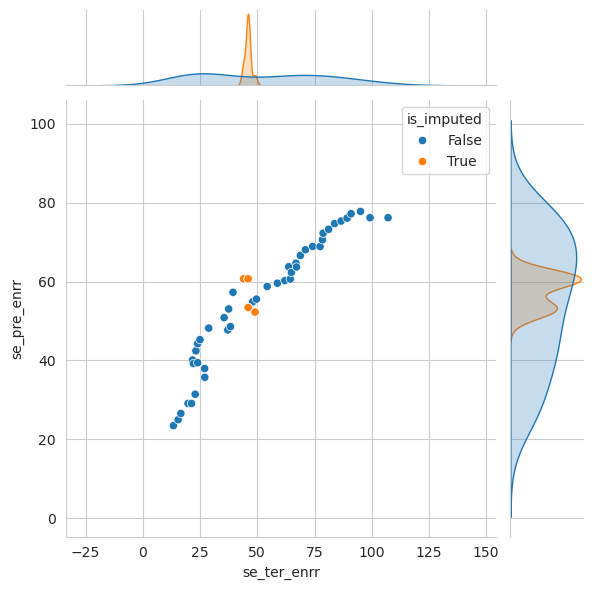

In [ ]:
plt.figure(figsize=(20,20))
arg_di_df_model.missing.scatter_imputation_plot(x="se_ter_enrr",y="se_pre_enrr",show_marginal=True)


## Multiple Imputation by Chained Equations (MICE)

It's a technique for imputing missing data, where multiple possible values are generated for each missing entry using iterative regression models.

By default, Scikit-Learn returns a single dataset, but this can be modified. You must provide values for all variables except the one you want to estimate.

<Axes: xlabel='sm_pop_refg_or', ylabel='se_ter_enrr'>

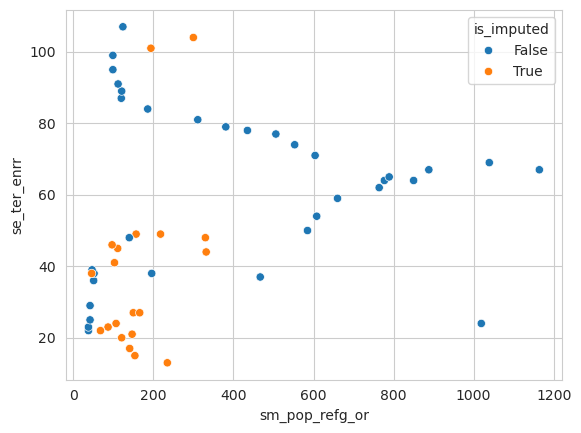

In [ ]:
mice_imputer = sklearn.impute.IterativeImputer(estimator=BayesianRidge())

arg_di_df_mice = arg_di_df_transformed.copy()
arg_di_df_mice.iloc[:,:] = mice_imputer.fit_transform(arg_di_df_mice).round()

arg_di_df_mice = (
    pd.concat(
        [
            arg_di_df_mice,
            arg_di_df.missing.create_shadow_matrix(True,False,True,"_imp")
        ],
        axis=1
    )
)

arg_di_df_mice.missing.scatter_imputation_plot(
    x=columns_with_missing_values[0],
    y=columns_with_missing_values[1]
)

### Inverse transformation of data

In [ ]:
arg_di_df_imputated = arg_di_df_mice.copy()

arg_di_df_imputated[categorical_columns] = (
    categorical_transformer
        .named_transformers_.ordinalencoder.inverse_transform(
            X = arg_di_df_mice[categorical_columns]
        )
)

print(arg_di_df_mice.missing.number_missing())

pd.concat(
    [
        arg_di_df_mice[categorical_columns],
        arg_di_df_imputated[categorical_columns]
    ],
    axis=1
).head(5)

NameError: name 'arg_di_df_mice' is not defined

Source: https://deepnote.com/workspace/platzi-escuela-datos-83832097-f136-43ff-b38d-abaa022e8ec7/project/datos-faltantes-imputacion-bdf84ff9-f66c-44c7-a67c-ca1115a2b683/notebook/imputation-missing-values-60b90530690647e596864b472f71dfde

# Session info

In [ ]:
session_info.show()

/home/ubuntu/anaconda3/envs/research-on-argentina/lib/python3.11/site-packages/session_info/main.py:213: DeprecationWarning: Accessing jsonschema.__version__ is deprecated and will be removed in a future release. Use importlib.metadata directly to query for jsonschema's version.
  mod_version = _find_version(mod.__version__)


KeyError: 'backports'